# Imports - DO NOT TOUCH, just hit run all (play button)

In [ ]:
!pip install orjson
!pip install pytrends

import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import orjson
import datetime
from datetime import timedelta
from pytrends.request import TrendReq
from dateutil import parser
from tqdm import tqdm
import warnings
from functools import reduce
from time import sleep
import ast
import statistics as s
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
import joblib
import numpy as np

!wget https://github.com/nathanchong25/film_ml/raw/main/30_opening.joblib
!wget https://github.com/nathanchong25/film_ml/raw/main/60_opening.joblib
!wget https://github.com/nathanchong25/film_ml/raw/main/90_opening.joblib

!wget https://github.com/nathanchong25/film_ml/raw/main/30_all_adjusted.joblib
!wget https://github.com/nathanchong25/film_ml/raw/main/60_all_adjusted.joblib
!wget https://github.com/nathanchong25/film_ml/raw/main/90_all_adjusted.joblib

!wget https://github.com/nathanchong25/film_ml/raw/main/30_all_total.joblib
!wget https://github.com/nathanchong25/film_ml/raw/main/60_all_total.joblib
!wget https://github.com/nathanchong25/film_ml/raw/main/90_all_total.joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 2.0 MB/s eta 0:00:00
--2023-08-14 15:20:12--  https://github.com/nathanchong25/film_ml/raw/main/30_opening.joblib
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nathanchong25/film_ml/main/30_opening.joblib [following]
--2023-08-14 15:20:13--  https://raw.githubusercontent.com/nathanchong25/film_ml/main/30_opening.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74573 (73K) [application/octet-stream]
Saving to: ‘30_opening.joblib’

30_opening.joblib   100%[===================>]  72.83K  --.-KB/s    in 0.005s  

2023-08-14 15:20:13

# Prebuilt Data Functions - DO NOT TOUCH, just hit run all (play button)

In [ ]:
def filter_it(subset):
  if len(subset) > 90:
    a = {}
    a['wiki_earliest_set_pure'] = subset[-90:-60]
    a['wiki_earliest_set_com'] = subset[-90:]
    a['wiki_mid_set_pure'] = subset[-60:-30]
    a['wiki_mid_set_com'] = subset[-60:]
    a['wiki_latest_set'] = subset[-30:]
    a['wiki_all_data'] = subset
    return a
  elif len(subset) > 60:
    a = {}
    a['wiki_earliest_set_pure'] = None
    a['wiki_earliest_set_com'] = subset[-90:]
    a['wiki_mid_set_pure'] = subset[-60:-30]
    a['wiki_mid_set_com'] = subset[-60:]
    a['wiki_latest_set'] = subset[-30:]
    a['wiki_all_data'] = subset
  elif len(subset) > 30:
    a = {}
    a['wiki_earliest_set_pure'] = None
    a['wiki_earliest_set_com'] = None
    a['wiki_mid_set_pure'] = None
    a['wiki_mid_set_com'] = subset[-60:]
    a['wiki_latest_set'] = subset[-30:]
    a['wiki_all_data'] = subset
  else:
    a = {}
    a['wiki_earliest_set_pure'] = None
    a['wiki_earliest_set_com'] = None
    a['wiki_mid_set_pure'] = None
    a['wiki_mid_set_com'] = None
    a['wiki_latest_set'] = None
    a['wiki_all_data'] = subset
  return a

def get_creation(wikipedia_link, session):
  title = wikipedia_link.split('/')[-1]
  revisions_url = f'https://en.wikipedia.org/w/api.php?action=query&format=json&titles={title}&prop=revisions&rvprop=timestamp&rvlimit=1&rvdir=newer'
  response = session.get(revisions_url, headers={'User-Agent':'Mozilla/5.0'})
  data = response.json()
  page_id = list(data['query']['pages'].keys())[0]
  revision_date_str = data['query']['pages'][page_id]['revisions'][0]['timestamp']
  revision_date_obj = datetime.datetime.strptime(revision_date_str, '%Y-%m-%dT%H:%M:%SZ')
  return revision_date_obj.strftime('%Y%m%d')

def get_release(wikipedia_link, session):
  try:
    response = session.get(wikipedia_link, headers={'User-Agent': 'Mozilla/5.0'})
    page_content = response.text
    soup = BeautifulSoup(page_content, 'html.parser')
    table = soup.find('table', class_='infobox vevent')
    rows = soup.find_all('tr')

    for row in rows:
      if "Release dates" in row.text:
        listy = row.text.strip().split('\n')
        for item in listy:
          if 'United States' in item or 'US' in item:
            result = re.sub(r'\([^)]*\)', '', item)
            result = result.replace('\xa0', ' ').strip()
            parsed_date = parser.parse(result)
            return parsed_date.strftime('%Y%m%d')
        for item in listy:
          if '(' in item:
            result = re.sub(r'\([^)]*\)', '', item)
            result = result.replace('\xa0', ' ').strip()
            parsed_date = parser.parse(result)
            return parsed_date.strftime('%Y%m%d')

      elif 'Release date' in row.text:
        listy = row.text.strip().split('\n')
        for item in listy:
          if '(' in item:
            result = re.sub(r'\([^)]*\)', '', item)
            result = result.replace('\xa0', ' ').strip()
            parsed_date = parser.parse(result)
            return parsed_date.strftime('%Y%m%d')
  except:
    return None

def api_call(url, first_date, end_date, session):
    end_part = url.split('/')[-1]
    api = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{end_part}/daily/{first_date}/{end_date}'
    resp = session.get(api, headers={'User-Agent':'Mozilla/5.0'})
    json_data = orjson.loads(resp.content)

    start = datetime.datetime.strptime(first_date, '%Y%m%d')
    stop = datetime.datetime.strptime(end_date, '%Y%m%d')

    views_dict = {item['timestamp'][:8]: item['views'] for item in json_data['items']}

    current_date = start
    j_data = []
    while current_date <= stop:
        j_data.append(views_dict.get(current_date.strftime('%Y%m%d'), 0))
        current_date += datetime.timedelta(days=1)

    return j_data

def get_wiki(link, session, timestamp, date_obj):
  release = get_release(link, session)
  release_date = datetime.datetime.strptime(release, '%Y%m%d').date()
  days_until_release = (release_date - date_obj).days
  if days_until_release != timestamp:
    warnings.warn('Date is not in the calibrated timestamps: 30, 60, 90 days pre-release. Models are only configured for those times.')

  creation = get_creation(link, session)
  data = api_call(link, creation, datetime.datetime.strftime(date_obj, format='%Y%m%d'), session)
  if timestamp == 90:
    x = filter_it(data[:-90])
  elif timestamp == 60:
    x = filter_it(data[:-60])
  elif timestamp == 30:
    x = filter_it(data[:-30])
  else:
    raise ValueError('Not valid timestamp entry.')

  x['wikipedia_url'] = link
  x['release'] = release
  return x

In [ ]:
def ready_title(text):
  title = re.sub(r'\([^)]*\)', '', text)
  title = title.strip()
  if len(title) >= 100:
    film_title = film_title[:99]
    a = film_title.rfind(':')
    if a == -1:
      return film_title[:a]
    else:
      return film_title[:a]
  else:
    return title

def get_trends_data(film_title, release, t, timestamp, date_obj):
  a = {'title': film_title}
  film_title = ready_title(film_title)
  release = datetime.datetime.strptime(release, "%Y%m%d")
  end = date_obj

  times = {
      'gt_earliest_set_pure': (90, 0),
      'gt_earliest_set_raw': (90, 60),
      'gt_mid_set_pure': (60, 30),
      'gt_mid_set_com': (60, 0),
      'gt_latest_set': (30,0)
    }

  for key, item in times.items():
    start_date = (end - datetime.timedelta(item[0])).strftime('%Y-%m-%d')
    end_date = (end - datetime.timedelta(item[1])).strftime('%Y-%m-%d')
    retry = True
    while retry:
      try:
        t.build_payload(kw_list=[film_title], timeframe=f'{start_date} {end_date}')
        trends_data = t.interest_over_time()
        trends_data = trends_data.rename(columns={film_title: 'film'})

        try:
          a[key] = trends_data['film'].to_list()
          sleep(1)
          break

        except KeyError as e:
          print(e)
          index = film_title.rfind(':')
          if index == -1:
            film_title = film_title[: len(film_title) // 2]
          else:
            film_title = film_title[:index]

      except Exception as e:
        print(e,  ': rate limit hit - relaunching pull for', film_title)
        sleep(60)

  return a

# Prebuilt Machine Learning Functions - DO NOT TOUCH, just hit run all (play button)

In [ ]:
# Statistical analysis

def normalize_list(input_list):
    scaler = MinMaxScaler(feature_range=(0, 100))
    normalized_list = scaler.fit_transform([[x] for x in input_list])
    return normalized_list.ravel().tolist()

def temp_solution(text):
  try:
    return ast.literal_eval(str(text))
  except ValueError:
    if str(text).lower() == "nan":
      return None  # or you can return "nan" or any other placeholder value
    else:
      raise

def try_std(x):
  try:
    return s.stdev(x) if x is not None else None
  except ValueError:
    return None

def analyze(df):
  df = df.copy()

  transformations = [('sum', lambda x: sum(x)  if x is not None else None),
                     ('avg', lambda x: s.mean(x) if x is not None else None),
                     ('std', try_std),
                      #lambda x: s.stdev(x) if x is not None else None),
                     ('median', lambda x: s.median(x)  if x is not None else None),
                     ('mode', lambda x: s.mode(x)  if x is not None else None),
                     ('range', lambda x: max(x) - min(x)  if x is not None else None),
                     ('iqr', lambda x:  s.quantiles(x, n=4)[-1] - (s.quantiles(x, n=4)[0])  if x is not None else None),
                    ]

  '''
  for column in df.drop(columns=['title', 'release']):

    if ('skew' not in column) and ('kurtosis' not in column):
      for x in transformations:
        df[column + '_' + x[0]] = df[column].apply(x[1])
    df = df.drop(column, axis=1)
  '''

  new_cols = []
  drop_col = []
  for column in tqdm(df.drop(columns=['title', 'release', 'date']), desc='{Analyzing data: }'):
      if ('skew' not in column) and ('kurtosis' not in column):
          temp_df = pd.DataFrame()
          for x in transformations:
            temp_df[column + '_' + x[0]] = df[column].apply(x[1])
            drop_col.append(column)
          new_cols.append(temp_df)

  df = pd.concat([df, *new_cols], axis=1)
  df = df.drop(columns = drop_col)

  return df

def expand(df):
  df = df.copy()
  df = df.drop('wikipedia_url', axis=1)
  df['wiki_all_data'] = df['wiki_all_data'].apply(lambda x: None if x == [] else x)
  first = df.drop(columns=['title', 'release', 'date'])

  for column in first:
    #df[column + '_skew'] = df[column].apply(lambda x: stats.skew(x) if x is not None else None)
    #df[column + '_kurtosis'] = df[column].apply(lambda x: stats.kurtosis(x) if x is not None else None)
    if 'wiki' in column:
      df[column + '_norm'] = df[column].apply(lambda x: normalize_list(x) if x is not None else None)

  df = analyze(df)

  return df.copy()

In [ ]:
def normal_pull(df, timeframe):
  session = requests.Session()
  t = TrendReq()

  tqdm.pandas(desc='{Wikipedia Data Pull}')
  df['wiki_data'] = df.progress_apply(lambda x: get_wiki(x['wikipedia_url'], session, timeframe, datetime.datetime.strptime(str(x['date']), '%Y%m%d').date()), axis = 1)
  wiki_df = pd.json_normalize(df['wiki_data'])
  df = pd.merge(df, wiki_df, how='inner', on='wikipedia_url').drop(columns=['wiki_data'])

  tqdm.pandas(desc='{Google Trends Pull - may take multiple iterations}')
  df['gt_data'] = df.progress_apply(lambda x: get_trends_data(x['title'], x['release'], t, timeframe, datetime.datetime.strptime(str(x['date']), '%Y%m%d').date()), axis=1)
  gt_df = pd.json_normalize(df['gt_data'])
  df = pd.merge(df, gt_df, how='inner', on='title').drop(columns=['gt_data'])
  df = expand(df)

  return df

def master_df(timeframe):

  file_test = True
  while file_test:
    filepath = input('Enter filename (ensure file is uploaded in Files on the left, enter as file.csv or file.xlsx): ')

    if filepath[-4:] == '.csv':
      try:
        df = pd.read_csv('/content/' + filepath)
        if 'Unnamed: 0' in set(df.columns):
          df = df.drop('Unnamed: 0', axis = 1)
        elif '' in set(df.columns):
          df = df.drop('', axis = 1)
        if set(df.columns) == {'title', 'wikipedia_url', 'date'}:
          file_test = False
        else:
          print('Table columns are incorrect - check input file is in the correct format.')
      except FileNotFoundError:
        print('File not found - check filename and ensure file is uploaded in the right location (content folder).')
      except:
        print('Problem reading input file - check input file is in the correct format.')

    elif filepath[-5:] == '.xlsx':
      try:
        warnings.warn('Excel file must only be one sheet.')
        df = pd.read_excel('/content/' + filepath)
        if 'Unnamed: 0' in set(df.columns):
          df = df.drop('Unnamed: 0', axis = 1)
        elif '' in set(df.columns):
          df = df.drop('', axis = 1)
        if set(df.columns) == {'title', 'wikipedia_url', 'date'}:
          file_test = False
        else:
          print('Table columns are incorrect - check input file is in the correct format.')
      except FileNotFoundError:
        print('File not found - check filename and ensure file is uploaded in the right location (content folder).')
      except ValueError:
        print('Problem reading input file - ensure that the Excel file is only one sheet.')
      except:
        print('Problem reading input file - check input file is in the correct format.')
    else:
       print('Faulty input - program only accepts CSV (.csv) and Excel (.xlsx) files.')

  return normal_pull(df, timeframe)

def master_indiv(timeframe):
  film_test = True
  while film_test:
    film = input('Enter film name in the format OFFICIAL TITLE (YYYY): ').strip()
    if bool(re.search(r' \(\d{4}\)', film)) == False:
      print('Faulty input - try again. Ensure the film is in the correct format.')
    else:
      film_test = False

  link_test = True
  while link_test:
    link = input('Enter unaltered Wikipedia url for film (https://en.wikipedia.org/wiki/{official_page_title}): ').strip()
    if 'https://en.wikipedia.org/wiki/' not in link:
      print('Faulty input - try again. Ensure the film is in the correct format.')
    else:
      link_test = False

  date_test = True
  while date_test:
    date = input('Enter date for timeframe (ensure is in YYYYMMDD format): ').strip()
    if len(date) != 8:
      print('Faulty input - try again. Ensure the date is in the correct format.')
    elif date.isnumeric() == False:
      print('Faulty input - try again. Ensure the date is in the correct format.')
    else:
      date_test = False

  dicto = {'title': [film], 'wikipedia_url': [link], 'date': date}
  df = pd.DataFrame(dicto)

  return normal_pull(df, timeframe)

In [ ]:
def get_prediction(filename, row):
  data = joblib.load(filename)
  ml = data[0]
  rsq = data[1]
  hyper = data[2]
  input_data = np.array(row).reshape(1, -1)
  prediction = ml.predict(input_data)[0]
  return (prediction, rsq, hyper)

def get_series_from_prediction(filename, row):
  prediction = get_prediction(filename, row)
  return pd.Series([prediction[0], prediction[1], prediction[2]])

def run_ml(df, timestamp):
  new_df = df['title']
  df = df.drop(columns=['title', 'release', 'date'])
  for x in ['opening', 'all_total', 'all_adjusted']:
    filename = '/content/' + str(timestamp) + '_' + x + '.joblib'
    tqdm.pandas(desc='{Predicting: }')
    predictions_df = df.progress_apply(lambda x: get_series_from_prediction(filename, x), axis=1)
    predictions_df.columns = [x + '_prediction', x + '_rsq', x + '_hyperparameters']
    new_df = pd.concat([new_df, predictions_df], axis=1)
  return new_df

def main():
  time_test = True
  while time_test:
    try:
      timeframe = int(input('Enter timeframe (30, 60 or 90 days before release - model is not calibrated for other dates): ').strip())
    except ValueError:
      print('Faulty input - enter either 30, 60 or 90.')
    else:
      if timeframe not in [30, 60, 90]:
        print('Faulty input - model is only calibrated for 30, 60 and 90 days before release.')
      else:
        time_test = False

  input_test = True
  while input_test:
    choice = input('(O)ne film or (S)heet of films (enter O or S): ').strip()
    try:
      man = int(choice)
    except:
      pass
    if choice == 0 or choice == 'O':
      input_test = False
      input_df = master_indiv(timeframe)
    elif choice == 'S':
      input_test = False
      input_df = master_df(timeframe)
    else:
      print('Invalid input - type O or S.')

  ml_df = run_ml(input_df, timeframe)
  ml_df.to_excel('output.xlsx')
  return ml_df


# For User to Run

**IMPORTANT INSTRUCTIONS**

CALIBRATION

Before doing anything - run all the above sections. All you need to do is click the play buttons from top to bottom.

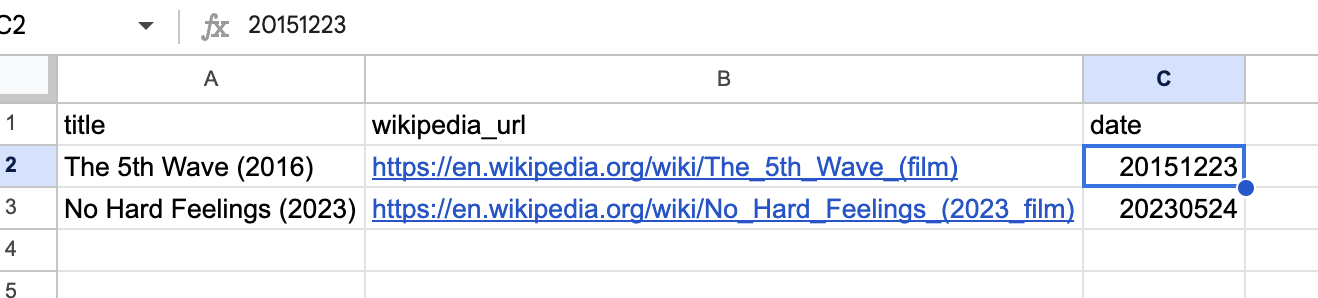

REGARDING INPUTS

Inputs must be exact for the model to run. The program will ask you to input text into the box.

If only trying to predict a single film, make sure the film is formated XXXX XXXX (YYYY); the official title of the film followed by the year of release in parentheses. Be careful not to include extra spaces in between. The Wikipedia link must be copied exactly from your browser bar or the whole program will fail. When entering the timestamp date, provide the date 30, 60, or 90 days before release as according to the timeframe you specified in the first step. The date must be formatted YYYYMMDD (20230810 for example) and cannot be in the future. There is no need to include the release date.

If trying to predict several films at once, you can upload inputs using Excel or as a CSV file. The sheet must be formatted exactly as follows: with a column titled "title", a column titled "wikipedia_url", and a column titled "date" (all lowercase). The date for each film must be the date 30, 60, or 90 days before release – the timeframe (30, 60 or 90) must be consistent across all rows. These must all be formatted YYYYMMDD (20230810 for example) and cannot be in the future. There is no need to include the release date.

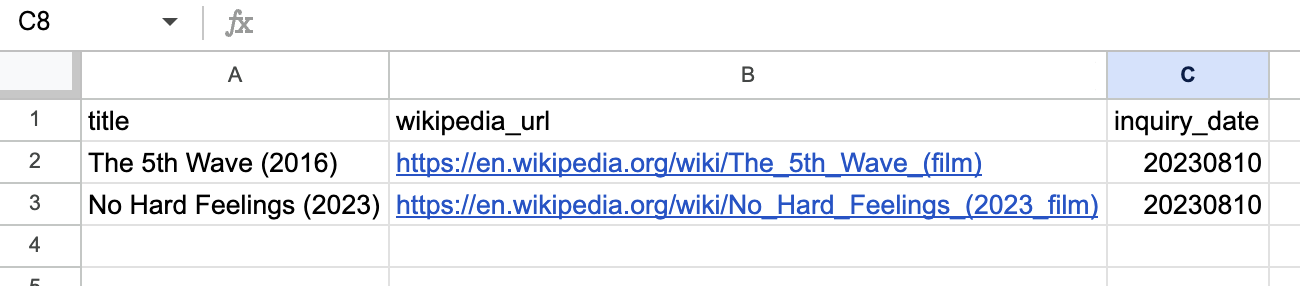

Upload the file to the folder icon on the left of the screen.

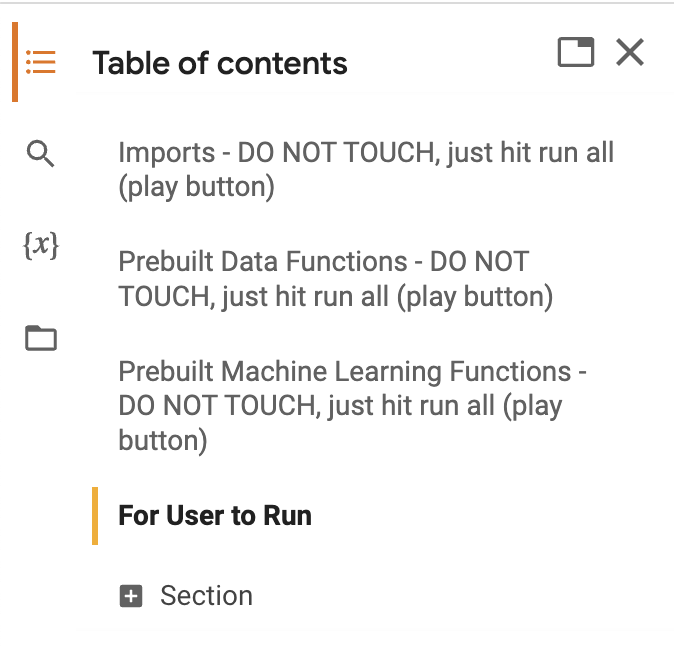

Then, click the file with an arrow icon at the top of the sidebar to upload your file.

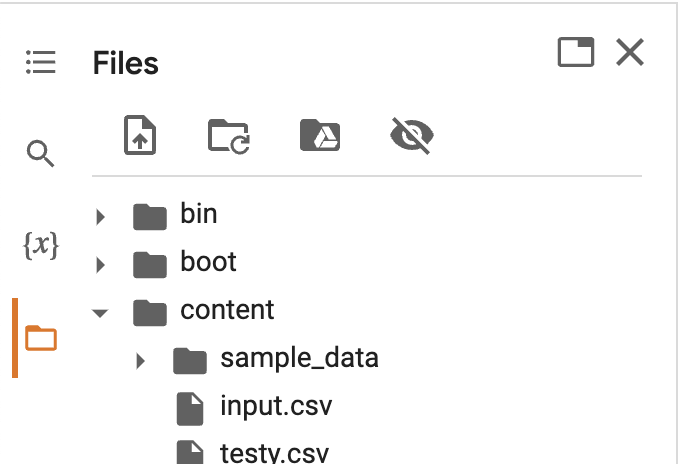

Be sure to get the filename (x.csv or x.xlsx) correct when prompted or it will ask you to re-enter the filename.

REGARDING TIMESTAMPS

The model is only configured to be run 30, 60, or 90 days in advance of release. Do not enter timestamp days as anything other than a day 30, 60, or 90 days before release.

REGARDING OUTPUT

The model will output 3 columns for each predicted metric (opening performance and total global performance). The first column is the predicted value, the second column is the RSQ of the model, and the third column is the parameter grid used. The RSQ will not change unless the model is reconfigured, and so for most cases, only the first column is relevant.

REGARDING TRAINING

We reccomend re-training the model periodically, as well as once with a larger sample once we leave. The more films you can provide as a sample to the model, the more accurate it will be. Instructions and code can be found here: https://colab.research.google.com/drive/1xTRlYR9-5ufrWSRPRDINB7FN1kr-nmmw?usp=sharing. The machine learning models themselves are stored in binary code at https://github.com/nathanchong25/film_ml/tree/main and will be updated if the above code is run, which will also flow down into this code.


Best of Luck.
Nathan and Kathy
TSG Summer Interns 2023
nathan.chong@stern.nyu.edu
kathy.lin@nyu.edu

In [ ]:
main()

Enter timeframe (30, 60 or 90 days before release - model is not calibrated for other dates): 30
(O)ne film or (S)heet of films (enter O or S): O
Enter film name in the format OFFICIAL TITLE (YYYY): Gran Turismo (2023)
Enter unaltered Wikipedia url for film (https://en.wikipedia.org/wiki/{official_page_title}): https://en.wikipedia.org/wiki/Gran_Turismo_(film)
Enter date for timeframe (ensure is in YYYYMMDD format): 20230723


{Wikipedia Data Pull}:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-2-99b4ed4673d9>:106: UserWarning: Date is not in the calibrated timestamps: 30, 60, 90 days pre-release. Models are only configured for those times.
  warnings.warn('Date is not in the calibrated timestamps: 30, 60, 90 days pre-release. Models are only configured for those times.')
{Wikipedia Data Pull}: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
{Google Trends Pull - may take multiple iterations}: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]
{Analyzing data: }: 17it [00:00, 203.16it/s]             
{Predicting: }:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
{Predicting: }:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomF

,title,opening_prediction,opening_rsq,opening_hyperparameters,all_total_prediction,all_total_rsq,all_total_hyperparameters,all_adjusted_prediction,all_adjusted_rsq,all_adjusted_hyperparameters
0,Gran Turismo (2023),1.284507e+07,0.831845,"{'subsample': 1.0, 'n_estimators': 50, 'min_sa...",1.094531e+08,0.848582,"{'n_estimators': 100, 'min_samples_split': 5, ...",1.470719e+08,0.706953,"{'subsample': 0.8, 'n_estimators': 100, 'min_s..."
